In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-approval-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3523739%2F6144787%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T150440Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D73d85fcb019203a5b535eb1aed03bb76550350416866649a3e7c719f7d1cf7f44300c8cf8167ab5b949f31cc1778b8ac5fdf6f3ebb5e5f7cb2e80df4eec25e2bce26a29cf3c68ea3703af75a4cfc91cfa7ef570fc6c4dc68bfba4c31f4ad24f43c08b3e33b36bbf2aa3b266535a64a97c2949cf6e29ecf1f3aea78973807515c4b88907a231e99353f5163b9351cf913bf296b673b117898e8df23781b39b9b51a9102a65032ba51c33e7c0f5c321688b5b932a034e39a93904468a17074de961d027a4e9a839a0b4dcce2a3f2c34e961e779ca1cb8f50133a85a7b1babb12ce469853e9e7d1c72c1cd0238457d7a920132139c4982245cfa475b2a6896386fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 82535 bytes downloaded
Downloaded and uncompressed: loan-approval-prediction-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


In [ ]:
import numpy
import sklearn
from sklearn import preprocessing
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [ ]:
import pandas as pd
loan_data = pd.read_csv("/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv")
loan_data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
label_encoder = preprocessing.LabelEncoder()
loan_data.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [ ]:
loan_data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
label_encoder_y = preprocessing.LabelEncoder()

In [ ]:
loan_data[' education'] = label_encoder.fit_transform(loan_data[' education'])
loan_data[' self_employed'] = label_encoder.fit_transform(loan_data[' self_employed'])
loan_data[' loan_status'] = label_encoder_y.fit_transform(loan_data[' loan_status'])
loan_data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,1
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,1


In [ ]:
# Gerekli kütüphaneleri yükleme
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Giriş ve çıkış verilerini ayırma
x = loan_data.drop(['loan_id', ' loan_status'], axis=1)
y = loan_data[' loan_status']

# Verileri ölçeklendirme
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Eğitim ve test veri kümelerini oluşturma
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# MLP modelini oluşturma ve eğitme
mlp_model = MLPClassifier()

# Parametre araması için grid oluşturma
params = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],
    'max_iter': [100],
    'random_state': [0]
}

grid_search = GridSearchCV(mlp_model, params, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
# Test verileri üzerinde tahmin yapma
y_pred_mlp = mlp.predict(x_test)

# En iyi parametreleri ve doğruluk skorunu yazdırma
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk skoru:", grid_search.best_score_)

# En iyi parametrelerle MLP modelini oluşturma ve eğitme
best_mlp_model = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
                               max_iter=grid_search.best_params_['max_iter'],
                               random_state=grid_search.best_params_['random_state'])
best_mlp_model.fit(x_train, y_train)

y_pred_mlp = best_mlp_model.predict(x_test)
print(classification_report(y_test, y_pred_mlp))
print('Accuracy score:', accuracy_score(y_test, y_pred_mlp)*100)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

En iyi parametreler: {'hidden_layer_sizes': (200,), 'max_iter': 100, 'random_state': 0}
En iyi doğruluk skoru: 0.9496339677891654
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       536
           1       0.94      0.94      0.94       318

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854

Accuracy score: 95.43325526932084


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
grid_search.best_estimator_

MLPClassifier(hidden_layer_sizes=(200,), max_iter=100, random_state=0)

In [42]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

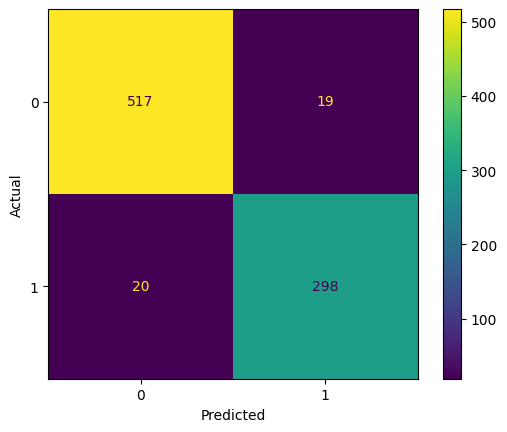

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()